# packages and imports

In [3]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statistics import mean

from sklearn.preprocessing import MinMaxScaler

from alibi.explainers import IntegratedGradients


from data_makers import *
import utils
from utils import *
import mean_model
from mean_model import meanModel
import ML_models
from ML_models import *

import sklearn

from sklearn.metrics import mean_squared_error, r2_score

from Nikhil_code import data_preprocessing as dp_nb
from Nikhil_code import model_selection as ms_nb
from Nikhil_code import testing as t_nb
import Nikhil_code.Data_imports as di_nb
import Nikhil_code.pairs_train_test_split as tts_nb
import Nikhil_code.Learning_curve as lc_nb

import shap

2023-08-23 13:19:25.313288: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 13:19:25.474248: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-23 13:19:25.481119: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-23 13:19:25.481141: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

# Feature selection (FS) and data creating for each drug

In [3]:
#input data
prot, rna, phospho_ls, one_hot_cls, one_hot_drugs, ic50_df1 = di_nb.read_input_data(transformation='norm')
_all_cls = prot.index
_all_drugs = ic50_df1.columns
assert prot.shape[0] == rna.shape[0] == phospho_ls.shape[0]
assert phospho_ls.shape[0]  == one_hot_cls.shape[0]
prot.shape, rna.shape, phospho_ls.shape, one_hot_cls.shape, one_hot_drugs.shape

Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.


Number of missing prot values 0.386335609896865
num non overlapping prot and target cls: 10


Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.


num non overlapping cls: 930


((38, 8457), (38, 17417), (38, 22804), (38, 38), (345, 345))

In [4]:
##PHOSPHO
#create prot data for all drugs
x_all_phos, x_drug, y_main_phos = dp_nb.create_all_drugs(
    phospho_ls, one_hot_drugs, ic50_df1, _all_cls)

#fmt index to include drug cell line paris
cls_drugs_index = x_all_phos.index + '::' + x_drug.index 
x_all_phos.index = cls_drugs_index
y_main_phos.index = cls_drugs_index
x_drug.index = cls_drugs_index

x_all_phos = x_all_phos.astype(np.float32)
print(x_all_phos.shape)
X_main_phos = X_main_maker(x_all_phos, x_drug, short = False)
print(X_main_phos.shape)

(11583, 22804)
(11583, 23149)


In [5]:
##PROTEOMIC
#create prot data for all drugs
x_all_prot, x_drug, y_list = dp_nb.create_all_drugs(
    prot, one_hot_drugs, ic50_df1, _all_cls)

#fmt index to include drug cell line paris
cls_drugs_index = x_all_prot.index + '::' + x_drug.index 
x_all_prot.index = cls_drugs_index
y_list.index = cls_drugs_index
x_drug.index = cls_drugs_index

x_all_prot = x_all_prot.astype(np.float32)
print(x_all_prot.shape)
X_main_prot = X_main_maker(x_all_prot, x_drug, short = False)
print(X_main_prot.shape)

(11583, 8457)
(11583, 8802)


In [6]:
#one hot data creation for all drugs
x_hot, x_drug_hot, y_main_onehot = dp_nb.create_all_drugs(
    one_hot_cls, one_hot_drugs, ic50_df1, _all_cls)

cls_drugs_index_hot = x_hot.index + '::' + x_drug_hot.index 

x_hot.index = cls_drugs_index_hot
x_hot.columns = np.arange(len(x_drug.columns), len(x_drug.columns) + len(x_hot.columns))
print(x_hot.shape)
X_main_onehot = X_main_maker(x_hot, x_drug, short = False)
print(X_main_onehot.shape)

(11583, 38)
(11583, 383)


# Early stopping and parameters

In [7]:
# set early stopping and learning rate scheduler
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, min_delta=0, restore_best_weights=True)
lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)
callbacks_list =  [es,lr_scheduler]

In [8]:
# set parameters and train
num_epochs = 200 # max epoch for training
learning_rate = 1e-2 # initial learning rate, decays via learning rate scheduler
momentum = 0.5
initializer_seed = 42

# Filter for drugs, features or all

In [ ]:
dtype='phospho'
model_type = 'rfr'

In [ ]:
# function that filters the X and y dataframe according to the Anti-Cancer drug database 
test_type = 'drugs_features'

if dtype == 'phospho':
    dd_X_phos, dd_ic50_df1, dd_one_hot_drugs = phospho_target_maker(X_main_phos, phospho_ls, ic50_df1, one_hot_drugs, ctype='all')
elif dtype == 'proteomic':
    dd_X_prot, dd_ic50_df1, dd_one_hot_drugs = proteomic_target_maker(X_main_prot, prot, ic50_df1, one_hot_drugs, ctype='all')
elif dtype == 'full_network':
    dd_X_phos, dd_ic50_df1, dd_one_hot_drugs = phospho_target_maker(X_main_phos, phospho_ls, ic50_df1, one_hot_drugs, ctype='all')
    dd_X_prot, dd_ic50_df1, dd_one_hot_drugs = proteomic_target_maker(X_main_prot, prot, ic50_df1, one_hot_drugs, ctype='all')
    dd_X = pd.concat([dd_X_phos, dd_X_prot], axis=1)


#create prot data for all drugs
dd_x_all, dd_x_drug, dd_y_main = dp_nb.create_all_drugs(
dd_X_prot, dd_one_hot_drugs, dd_ic50_df1, _all_cls)

#fmt index to include drug cell line paris
cls_drugs_index = dd_x_all.index + '::' + dd_x_drug.index 
dd_x_all.index = cls_drugs_index
dd_y_main.index = cls_drugs_index
dd_x_drug.index = cls_drugs_index

dd_x_all = dd_x_all.astype(np.float32)
print(dd_x_all.shape)
dd_X_main = X_main_maker(dd_x_all, dd_x_drug, short = False)
print(dd_X_main.shape)

## ONE HOT
#one hot data creation for all drugs
x_hot, x_drug_hot, y_main_onehot = dp_nb.create_all_drugs(
    one_hot_cls, dd_one_hot_drugs, dd_ic50_df1, _all_cls)

cls_drugs_index_hot = x_hot.index + '::' + x_drug_hot.index 

x_hot.index = cls_drugs_index_hot
x_hot.columns = np.arange(len(dd_x_drug.columns), len(dd_x_drug.columns) + len(x_hot.columns))
print(x_hot.shape)
X_main_onehot = X_main_maker(x_hot, dd_x_drug, short = False)
print(X_main_onehot.shape)

In [ ]:
#CHANGE JUST CL:DRUG

test_type = 'drugs'

# function that filters the X and y dataframe according to the Anti-Cancer drug database 
if dtype == 'phospho':
    dd_X_phos, dd_ic50_df1, dd_one_hot_drugs = phospho_target_maker(X_main_phos, phospho_ls, ic50_df1, one_hot_drugs, ctype='drug')
elif dtype == 'proteomic':
    dd_X_prot, dd_ic50_df1, dd_one_hot_drugs = proteomic_target_maker(X_main_prot, prot, ic50_df1, one_hot_drugs, ctype='drug')
elif dtype == 'full_network':
    dd_X_phos, dd_ic50_df1, dd_one_hot_drugs = phospho_target_maker(X_main_phos, phospho_ls, ic50_df1, one_hot_drugs, ctype='drug')
    dd_X_prot, dd_ic50_df1, dd_one_hot_drugs = proteomic_target_maker(X_main_prot, prot, ic50_df1, one_hot_drugs, ctype='drug')
    dd_X = pd.concat([dd_X_phos, dd_X_prot], axis=1)


#create prot data for all drugs
dd_x_all, dd_x_drug, dd_y_main = dp_nb.create_all_drugs(
dd_X_prot, dd_one_hot_drugs, dd_ic50_df1, _all_cls)

#fmt index to include drug cell line paris
cls_drugs_index = dd_x_all.index + '::' + dd_x_drug.index 
dd_x_all.index = cls_drugs_index
dd_y_main.index = cls_drugs_index
dd_x_drug.index = cls_drugs_index

dd_x_all = dd_x_all.astype(np.float32)
print(dd_x_all.shape)
dd_X_main = X_main_maker(dd_x_all, dd_x_drug, short = False)
print(dd_X_main.shape)

## ONE HOT
#one hot data creation for all drugs
x_hot, x_drug_hot, y_main_onehot = dp_nb.create_all_drugs(
    one_hot_cls, dd_one_hot_drugs, dd_ic50_df1, _all_cls)

cls_drugs_index_hot = x_hot.index + '::' + x_drug_hot.index 

x_hot.index = cls_drugs_index_hot
x_hot.columns = np.arange(len(x_drug.columns), len(x_drug.columns) + len(x_hot.columns))
print(x_hot.shape)
X_main_onehot = X_main_maker(x_hot, dd_x_drug, short = False)
print(X_main_onehot.shape)

In [ ]:
#CHANGE JUST FEATURES

test_type = 'features'

# function that filters the X and y dataframe according to the Anti-Cancer drug database 
if dtype == 'phospho':
    dd_X_phos, dd_ic50_df1, dd_one_hot_drugs = phospho_target_maker(X_main_phos, phospho_ls, ic50_df1, one_hot_drugs, ctype='feature')
elif dtype == 'proteomic':
    dd_X_prot, dd_ic50_df1, dd_one_hot_drugs = proteomic_target_maker(X_main_prot, prot, ic50_df1, one_hot_drugs, ctype='feature')
elif dtype == 'full_network':
    dd_X_phos, dd_ic50_df1, dd_one_hot_drugs = phospho_target_maker(X_main_phos, phospho_ls, ic50_df1, one_hot_drugs, ctype='feature')
    dd_X_prot, dd_ic50_df1, dd_one_hot_drugs = proteomic_target_maker(X_main_prot, prot, ic50_df1, one_hot_drugs, ctype='feature')
    dd_X = pd.concat([dd_X_phos, dd_X_prot], axis=1)


#create prot data for all drugs
dd_x_all, dd_x_drug, dd_y_main = dp_nb.create_all_drugs(
dd_X_phos, dd_one_hot_drugs, dd_ic50_df1, _all_cls)

#fmt index to include drug cell line paris
cls_drugs_index = dd_x_all.index + '::' + dd_x_drug.index 
dd_x_all.index = cls_drugs_index
dd_y_main.index = cls_drugs_index
dd_x_drug.index = cls_drugs_index

dd_x_all = dd_x_all.astype(np.float32)
print(dd_x_all.shape)
dd_X_main = X_main_maker(dd_x_all, dd_x_drug, short = False)
print(dd_X_main.shape)

## ONE HOT
#one hot data creation for all drugs
x_hot, x_drug_hot, y_main_onehot = dp_nb.create_all_drugs(
    one_hot_cls, dd_one_hot_drugs, dd_ic50_df1, _all_cls)

cls_drugs_index_hot = x_hot.index + '::' + x_drug_hot.index 

x_hot.index = cls_drugs_index_hot
x_hot.columns = np.arange(len(x_drug_hot.columns), len(x_drug.columns) + len(x_hot.columns))
print(x_hot.shape)
X_main_onehot = X_main_maker(x_hot, dd_x_drug, short = False)
print(X_main_onehot.shape)

# Test models for drug targets

reform dataframes to only contain drugs and targets that have known interactions

## Random forest

drug and features filtered

In [ ]:
rs = [0, 8, 23, 42, 69, 88]
mm_r2 = []
model_r2 = []
model_standard_error = []
mixed_set_r2 = []
model_MSE = []
model_pearson = []

for seed in rs:
    print(f'Seed: {seed}')
    #tts
    dd_X_train, dd_X_test, dd_y_train, dd_y_test = cell_line_split(dd_X_main, dd_y_main, test_size=0.2, random_state = seed)
    #run mean model
    dl = dlMaker(dd_y_train, noRepeats=True)
    mm = meanModel(dd_y_train, dl)
    prediction = mm.predict(dd_y_test.index)
    mean_r2 = r2_score(dd_y_test, list(prediction.values()))
    mm_r2.append(mean_r2)
    
    print(f'Mixed-Set Model')
    #MIXED SET
    #MODEL
    if model_type == 'rfr':
        r2, MSE, pearson, standard_error = rfr(X_main_onehot, dd_y_main, test_size=0.2, random_state=seed, iterations=3)
    elif model_type == 'xgb':
        r2, MSE, pearson, standard_error = xgb(X_main_onehot, dd_y_main, test_size=0.2, random_state=seed, iterations=3)
    mixed_set_r2.append(r2)

    #random forests
    if model_type == 'rfr':
        r2, MSE, pearson, standard_error = rfr(dd_X_main, dd_y_main, test_size=0.2, random_state=seed, iterations=3)
    elif model_type == 'xgb':
        r2, MSE, pearson, standard_error = xgb(dd_X_main, dd_y_main, test_size=0.2, random_state=seed, iterations=3)
    model_r2.append(r2)
    model_standard_error.append(standard_error)
    model_MSE.append(MSE)
    model_pearson.append(pearson)

In [ ]:
table_make(f'drugs_features_{dtype}',
           [rs, mm_r2, mixed_set_r2, model_r2, model_standard_error, model_MSE, model_pearson],
           ['rs', 'mm_r2', 'mixed_set_r2', 'model_r2', 'model_standard_error', 'model_MSE', 'model_pearson'], 
           file = f'Targets/{model_type}/model performance/{dtype}/drugs_features_{dtype}_NORMX.csv')
           

drugs filtered only

In [ ]:
rs = [0, 8, 23, 42, 69, 88]
mm_r2 = []
model_r2 = []
model_standard_error = []
mixed_set_r2 = []
model_MSE = []
model_pearson = []

for seed in rs:
    print(f'Seed: {seed}')
    #tts
    dd_X_train, dd_X_test, dd_y_train, dd_y_test = cell_line_split(dd_X_main, dd_y_main, test_size=0.2, random_state = seed)
    #run mean model
    dl = dlMaker(dd_y_train, noRepeats=True)
    mm = meanModel(dd_y_train, dl)
    prediction = mm.predict(dd_y_test.index)
    mean_r2 = r2_score(dd_y_test, list(prediction.values()))
    mm_r2.append(mean_r2)
    
    print(f'Mixed-Set Model')
    #MIXED SET
    #MODEL
    if model_type == 'rfr':
        r2, MSE, pearson, standard_error = rfr(X_main_onehot, dd_y_main, test_size=0.2, random_state=seed, iterations=3)
    elif model_type == 'xgb':
        r2, MSE, pearson, standard_error = xgb(X_main_onehot, dd_y_main, test_size=0.2, random_state=seed, iterations=3)
    mixed_set_r2.append(r2)

    #random forests
    if model_type == 'rfr':
        r2, MSE, pearson, standard_error = rfr(dd_X_main, dd_y_main, test_size=0.2, random_state=seed, iterations=3)
    elif model_type == 'xgb':
        r2, MSE, pearson, standard_error = xgb(dd_X_main, dd_y_main, test_size=0.2, random_state=seed, iterations=3)
    model_r2.append(r2)
    model_standard_error.append(standard_error)
    model_MSE.append(MSE)
    model_pearson.append(pearson)

In [ ]:
table_make(f'drugs_{dtype}',
           [rs, mm_r2, mixed_set_r2, model_r2, model_standard_error, model_MSE, model_pearson],
           ['rs', 'mm_r2', 'mixed_set_r2', 'model_r2', 'model_standard_error', 'model_MSE', 'model_pearson'],
           f'Targets/{model_type}/model performance/{dtype}/drugs_{dtype}_NORMX.csv')

features filtered only

In [ ]:
rs = [0, 8, 23, 42, 69, 88]
mm_r2 = []
model_r2 = []
model_standard_error = []
mixed_set_r2 = []
model_MSE = []
model_pearson = []

for seed in rs:
    print(f'Seed: {seed}')
    #tts
    dd_X_train, dd_X_test, dd_y_train, dd_y_test = cell_line_split(dd_X_main, dd_y_main, test_size=0.2, random_state = seed)
    #run mean model
    dl = dlMaker(dd_y_train, noRepeats=True)
    mm = meanModel(dd_y_train, dl)
    prediction = mm.predict(dd_y_test.index)
    mean_r2 = r2_score(dd_y_test, list(prediction.values()))
    mm_r2.append(mean_r2)
    
    print(f'Mixed-Set Model')
    #MIXED SET
    #MODEL
    if model_type == 'rfr':
        r2, MSE, pearson, standard_error = rfr(X_main_onehot, dd_y_main, test_size=0.2, random_state=seed, iterations=3)
    elif model_type == 'xgb':
        r2, MSE, pearson, standard_error = xgb(X_main_onehot, dd_y_main, test_size=0.2, random_state=seed, iterations=3)
    mixed_set_r2.append(r2)

    #random forests
    if model_type == 'rfr':
        r2, MSE, pearson, standard_error = rfr(dd_X_main, dd_y_main, test_size=0.2, random_state=seed, iterations=3)
    elif model_type == 'xgb':
        r2, MSE, pearson, standard_error = xgb(dd_X_main, dd_y_main, test_size=0.2, random_state=seed, iterations=3)
    model_r2.append(r2)
    model_standard_error.append(standard_error)
    model_MSE.append(MSE)
    model_pearson.append(pearson)

In [ ]:
table_make(f'features_{dtype}',
           [rs, mm_r2, mixed_set_r2, model_r2, model_standard_error, model_MSE, model_pearson],
           ['rs', 'mm_r2', 'mixed_set_r2', 'model_r2', 'model_standard_error', 'model_MSE', 'model_pearson'],
           f'Targets/{model_type}/model performance/{dtype}/features_{dtype}_NORMX.csv')

## Neural Networks

drugs and features filtered

In [ ]:
rs = [0, 8, 23, 42, 69, 88]
mm_r2 = []
mixed_set_r2 = []
model_r2 = []
model_MSE = []
model_pearson = []

for seed in rs:
    
    print(f'Seed: {seed}')
    
    print(f'Mean Model')
    #MEAN MODEL
    #tts
    X_train, X_test, y_train, y_test = cell_line_split(dd_X_main, y=dd_y_main, test_size=0.2, random_state = seed)
    #run mean model
    dl = dlMaker(y_train, noRepeats=True)
    mm = meanModel(y_train, dl)
    prediction = mm.predict(y_test.index)
    mean_r2 = r2_score(y_test, list(prediction.values()))
    mm_r2.append(mean_r2)
    
    
    print(f'Mixed-Set Model')
    #phospho
    xo_train, xo_test = cell_line_split(x_hot, y=None, test_size=0.2, random_state = seed)
    xd_train, xd_test = cell_line_split(dd_x_drug, y=None, test_size=0.2, random_state = seed)
    y_train, y_test = cell_line_split(dd_y_main, y=None, test_size=0.2, random_state = seed)

    model = build_CNN(xo_train, xd_train, learning_rate, momentum, initializer_seed, mtype = 'regression')
    history = model.fit([xo_train, xd_train], y_train,
                        validation_data=([xo_test, xd_test], y_test),
                        epochs=num_epochs, 
                        batch_size=None, 
                        verbose=0, 
                        callbacks=callbacks_list)

    y_pred = model.predict([xo_test, xd_test])  
    r2 = r2_score(y_test, y_pred)
        
    mixed_set_r2.append(r2)

    print(f'Model: Deep_NN')
    
    #phospho
    xo_train, xo_test = cell_line_split(dd_x_all, y=None, test_size=0.2, random_state = seed)
    xd_train, xd_test = cell_line_split(dd_x_drug, y=None, test_size=0.2, random_state = seed)
    y_train, y_test = cell_line_split(dd_y_main, y=None, test_size=0.2, random_state = seed)
    
    ## Code for model building and training

    model = build_CNN(xo_train, xd_train, learning_rate, momentum, initializer_seed, mtype = 'regression')
    history = model.fit([xo_train, xd_train], y_train,
                        validation_data=([xo_test, xd_test], y_test),
                        epochs=num_epochs, 
                        batch_size=None, 
                        verbose=0, 
                        callbacks=callbacks_list)

    y_pred = model.predict([xo_test, xd_test])  
    r2 = r2_score(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    pearson = pearsonr(y_test, y_pred)
    model_r2.append(r2)
    model_MSE.append(MSE)
    model_pearson.append(pearson)


In [ ]:
table_make(f'drugs_features_{dtype}',
           [rs, mm_r2, mixed_set_r2, model_r2, model_MSE, model_pearson],
           ['rs', 'mm_r2', 'mixed_set_r2', 'model_r2', 'model_MSE', 'model_pearson'], 
           file = f'Targets/{model_type}/model performance/{dtype}/drugs_features_{dtype}.csv')
           

drugs filtered only

In [ ]:
rs = [0, 8, 23, 42, 69, 88]
mm_r2 = []
mixed_set_r2 = []
model_r2 = []
model_MSE = []
model_pearson = []

for seed in rs:
    
    print(f'Seed: {seed}')
    
    print(f'Mean Model')
    #MEAN MODEL
    #tts
    X_train, X_test, y_train, y_test = cell_line_split(dd_X_main, y=dd_y_main, test_size=0.2, random_state = seed)
    #run mean model
    dl = dlMaker(y_train, noRepeats=True)
    mm = meanModel(y_train, dl)
    prediction = mm.predict(y_test.index)
    mean_r2 = r2_score(y_test, list(prediction.values()))
    mm_r2.append(mean_r2)
    
    
    print(f'Mixed-Set Model')
    #phospho
    xo_train, xo_test = cell_line_split(x_hot, y=None, test_size=0.2, random_state = seed)
    xd_train, xd_test = cell_line_split(dd_x_drug, y=None, test_size=0.2, random_state = seed)
    y_train, y_test = cell_line_split(dd_y_main, y=None, test_size=0.2, random_state = seed)

    model = build_CNN(xo_train, xd_train, learning_rate, momentum, initializer_seed, mtype = 'regression')
    history = model.fit([xo_train, xd_train], y_train,
                        validation_data=([xo_test, xd_test], y_test),
                        epochs=num_epochs, 
                        batch_size=None, 
                        verbose=0, 
                        callbacks=callbacks_list)

    y_pred = model.predict([xo_test, xd_test])  
    r2 = r2_score(y_test, y_pred)
        
    mixed_set_r2.append(r2)

    print(f'Model: Deep_NN')
    
    #phospho
    xo_train, xo_test = cell_line_split(dd_x_all, y=None, test_size=0.2, random_state = seed)
    xd_train, xd_test = cell_line_split(dd_x_drug, y=None, test_size=0.2, random_state = seed)
    y_train, y_test = cell_line_split(dd_y_main, y=None, test_size=0.2, random_state = seed)
    
    ## Code for model building and training

    model = build_CNN(xo_train, xd_train, learning_rate, momentum, initializer_seed, mtype = 'regression')
    history = model.fit([xo_train, xd_train], y_train,
                        validation_data=([xo_test, xd_test], y_test),
                        epochs=num_epochs, 
                        batch_size=None, 
                        verbose=0, 
                        callbacks=callbacks_list)

    y_pred = model.predict([xo_test, xd_test])  
    r2 = r2_score(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    pearson = pearsonr(y_test, y_pred)
    model_r2.append(r2)
    model_MSE.append(MSE)
    model_pearson.append(pearson)


In [ ]:
table_make(f'drugs_{dtype}',
           [rs, mm_r2, mixed_set_r2, model_r2, model_MSE, model_pearson],
           ['rs', 'mm_r2', 'mixed_set_r2', 'model_r2', 'model_MSE', 'model_pearson'],
           f'Targets/{model_type}/model performance/{dtype}/drugs_{dtype}.csv')

features filtered only

In [ ]:
rs = [0, 8, 23, 42, 69, 88]
mm_r2 = []
mixed_set_r2 = []
model_r2 = []
model_MSE = []
model_pearson = []

for seed in rs:
    
    print(f'Seed: {seed}')
    
    print(f'Mean Model')
    #MEAN MODEL
    #tts
    X_train, X_test, y_train, y_test = cell_line_split(dd_X_main, y=dd_y_main, test_size=0.2, random_state = seed)
    #run mean model
    dl = dlMaker(y_train, noRepeats=True)
    mm = meanModel(y_train, dl)
    prediction = mm.predict(y_test.index)
    mean_r2 = r2_score(y_test, list(prediction.values()))
    mm_r2.append(mean_r2)
    
    
    print(f'Mixed-Set Model')
    #phospho
    xo_train, xo_test = cell_line_split(x_hot, y=None, test_size=0.2, random_state = seed)
    xd_train, xd_test = cell_line_split(dd_x_drug, y=None, test_size=0.2, random_state = seed)
    y_train, y_test = cell_line_split(dd_y_main, y=None, test_size=0.2, random_state = seed)

    model = build_CNN(xo_train, xd_train, learning_rate, momentum, initializer_seed, mtype = 'regression')
    history = model.fit([xo_train, xd_train], y_train,
                        validation_data=([xo_test, xd_test], y_test),
                        epochs=num_epochs, 
                        batch_size=None, 
                        verbose=0, 
                        callbacks=callbacks_list)

    y_pred = model.predict([xo_test, xd_test])  
    r2 = r2_score(y_test, y_pred)
        
    mixed_set_r2.append(r2)

    print(f'Model: Deep_NN')
    
    #phospho
    xo_train, xo_test = cell_line_split(dd_x_all, y=None, test_size=0.2, random_state = seed)
    xd_train, xd_test = cell_line_split(dd_x_drug, y=None, test_size=0.2, random_state = seed)
    y_train, y_test = cell_line_split(dd_y_main, y=None, test_size=0.2, random_state = seed)
    
    ## Code for model building and training

    model = build_CNN(xo_train, xd_train, learning_rate, momentum, initializer_seed, mtype = 'regression')
    history = model.fit([xo_train, xd_train], y_train,
                        validation_data=([xo_test, xd_test], y_test),
                        epochs=num_epochs, 
                        batch_size=None, 
                        verbose=0, 
                        callbacks=callbacks_list)

    y_pred = model.predict([xo_test, xd_test])  
    r2 = r2_score(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    pearson = pearsonr(y_test, y_pred)
    model_r2.append(r2)
    model_MSE.append(MSE)
    model_pearson.append(pearson)


In [ ]:
table_make(f'features_{dtype}',
           [rs, mm_r2, mixed_set_r2, model_r2, model_MSE, model_pearson],
           ['rs', 'mm_r2', 'mixed_set_r2', 'model_r2', 'model_MSE', 'model_pearson'],
           f'Targets/{model_type}/model performance/{dtype}/features_{dtype}.csv')

# performance plots

## individual model metrics

In [ ]:
dtype='phospho'
model_type = 'xgb'

In [ ]:
shap_df_full = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/drugs_features_{dtype}_NORMX.csv')
shap_df_drugs = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/drugs_{dtype}_NORMX.csv')
shap_df_features = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/features_{dtype}_NORMX.csv')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1
axes[0].plot(shap_df_full['rs'].astype(str), shap_df_full['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[0].plot(shap_df_full['rs'].astype(str), shap_df_full['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[0].plot(shap_df_full['rs'].astype(str), shap_df_full['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[0].set_title('Full Network')

# Plot 2
axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[1].set_title('Drugs Filtered')

# Plot 3
axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[2].set_title('Features Filtered')

axes[0].set_ylim(0.5, 0.85)
axes[1].set_ylim(0.5, 0.85)
axes[2].set_ylim(0.5, 0.85)


# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
dtype='proteomic'
model_type = 'xgb'

In [ ]:
shap_df_full = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/drugs_features_{dtype}_NORMX.csv')
shap_df_drugs = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/drugs_{dtype}_NORMX.csv')
shap_df_features = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/features_{dtype}_NORMX.csv')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1
axes[0].plot(shap_df_full['rs'].astype(str), shap_df_full['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[0].plot(shap_df_full['rs'].astype(str), shap_df_full['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[0].plot(shap_df_full['rs'].astype(str), shap_df_full['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[0].set_title('Full Network')

# Plot 2
axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[1].set_title('Drugs Filtered')

# Plot 3
axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[2].set_title('Features Filtered')

axes[0].set_ylim(0.5, 0.85)
axes[1].set_ylim(0.5, 0.85)
axes[2].set_ylim(0.5, 0.85)


# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
dtype='full_network'
model_type = 'xgb'

In [ ]:
shap_df_full = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/drugs_features_{dtype}_NORMX.csv')
shap_df_drugs = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/drugs_{dtype}_NORMX.csv')
shap_df_features = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/features_{dtype}_NORMX.csv')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1
axes[0].plot(shap_df_full['rs'].astype(str), shap_df_full['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[0].plot(shap_df_full['rs'].astype(str), shap_df_full['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[0].plot(shap_df_full['rs'].astype(str), shap_df_full['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[0].set_title('Full Network')

# Plot 2
axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[1].set_title('Drugs Filtered')

# Plot 3
axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[2].set_title('Features Filtered')

axes[0].set_ylim(0.5, 0.85)
axes[1].set_ylim(0.5, 0.85)
axes[2].set_ylim(0.5, 0.85)


# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
dtype='phospho'
model_type = 'rfr'

In [ ]:
shap_df_full = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/drugs_features_{dtype}_NORMX.csv')
shap_df_drugs = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/drugs_{dtype}_NORMX.csv')
shap_df_features = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/features_{dtype}_NORMX.csv')

fig, axes = plt.subplots(1, 1, figsize=(5, 5))

# Plot 1
axes.plot(shap_df_full['rs'].astype(str), shap_df_full['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes.plot(shap_df_full['rs'].astype(str), shap_df_full['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes.plot(shap_df_full['rs'].astype(str), shap_df_full['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes.set_title('drugs/features', style='italic')
axes.set_ylabel('r-squared')


# Plot 2
#axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
#axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
#axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
#axes[1].set_title('Drugs Filtered')

# Plot 3
#axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
#axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
#axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
#axes[2].set_title('Features Filtered')

axes.set_ylim(0.45, 0.85)
#axes[1].set_ylim(0.5, 0.85)
#axes[2].set_ylim(0.5, 0.85)

plt.savefig('plots/poor_result')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
dtype='proteomic'
model_type = 'rfr'

In [ ]:
shap_df_full = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/drugs_features_{dtype}.csv')
shap_df_drugs = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/drugs_{dtype}.csv')
shap_df_features = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/features_{dtype}.csv')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1
axes[0].plot(shap_df_full['rs'].astype(str), shap_df_full['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[0].plot(shap_df_full['rs'].astype(str), shap_df_full['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[0].plot(shap_df_full['rs'].astype(str), shap_df_full['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[0].set_title('Full Network')

# Plot 2
axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[1].set_title('Drugs Filtered')

# Plot 3
axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[2].set_title('Features Filtered')

axes[0].set_ylim(0.5, 0.85)
axes[1].set_ylim(0.5, 0.85)
axes[2].set_ylim(0.5, 0.85)


# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
dtype='full_network'
model_type = 'rfr'

In [ ]:
shap_df_full = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/drugs_features_{dtype}_NORMX.csv')
shap_df_drugs = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/drugs_{dtype}_NORMX.csv')
shap_df_features = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/features_{dtype}_NORMX.csv')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1
axes[0].plot(shap_df_full['rs'].astype(str), shap_df_full['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[0].plot(shap_df_full['rs'].astype(str), shap_df_full['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[0].plot(shap_df_full['rs'].astype(str), shap_df_full['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[0].set_title('Full Network')

# Plot 2
axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[1].set_title('Drugs Filtered')

# Plot 3
axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[2].set_title('Features Filtered')

axes[0].set_ylim(0.5, 0.85)
axes[1].set_ylim(0.5, 0.85)
axes[2].set_ylim(0.5, 0.85)


# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
dtype='phospho'
model_type = 'Deep_NN'

In [ ]:
shap_df_full = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/drugs_features_{dtype}.csv')
shap_df_drugs = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/drugs_{dtype}.csv')
shap_df_features = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/features_{dtype}.csv')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1
axes[0].plot(shap_df_full['rs'].astype(str), shap_df_full['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[0].plot(shap_df_full['rs'].astype(str), shap_df_full['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[0].plot(shap_df_full['rs'].astype(str), shap_df_full['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[0].set_title('Full Network')

# Plot 2
axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[1].set_title('Drugs Filtered')

# Plot 3
axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[2].set_title('Features Filtered')

axes[0].set_ylim(0.5, 0.85)
axes[1].set_ylim(0.5, 0.85)
axes[2].set_ylim(0.5, 0.85)


# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
dtype='proteomic'
model_type = 'Deep_NN'

In [ ]:
shap_df_full = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/drugs_features_{dtype}.csv')
shap_df_drugs = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/drugs_{dtype}.csv')
shap_df_features = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/features_{dtype}.csv')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1
axes[0].plot(shap_df_full['rs'].astype(str), shap_df_full['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[0].plot(shap_df_full['rs'].astype(str), shap_df_full['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[0].plot(shap_df_full['rs'].astype(str), shap_df_full['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[0].set_title('Full Network')

# Plot 2
axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[1].set_title('Drugs Filtered')

# Plot 3
axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[2].set_title('Features Filtered')

axes[0].set_ylim(0.5, 0.85)
axes[1].set_ylim(0.5, 0.85)
axes[2].set_ylim(0.5, 0.85)


# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
dtype='full_network'
model_type = 'Deep_NN'

In [ ]:
shap_df_full = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/drugs_features_{dtype}.csv')
shap_df_drugs = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/drugs_{dtype}.csv')
shap_df_features = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/features_{dtype}.csv')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1
axes[0].plot(shap_df_full['rs'].astype(str), shap_df_full['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[0].plot(shap_df_full['rs'].astype(str), shap_df_full['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[0].plot(shap_df_full['rs'].astype(str), shap_df_full['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[0].set_title('Full Network')

# Plot 2
axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[1].set_title('Drugs Filtered')

# Plot 3
axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[2].set_title('Features Filtered')

axes[0].set_ylim(0.5, 0.85)
axes[1].set_ylim(0.5, 0.85)
axes[2].set_ylim(0.5, 0.85)


# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
dtype='phospho'
model_type = 'CNN'

In [ ]:
shap_df_full = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/drugs_features_{dtype}.csv')
shap_df_drugs = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/drugs_{dtype}.csv')
shap_df_features = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/features_{dtype}.csv')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1
axes[0].plot(shap_df_full['rs'].astype(str), shap_df_full['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[0].plot(shap_df_full['rs'].astype(str), shap_df_full['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[0].plot(shap_df_full['rs'].astype(str), shap_df_full['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[0].set_title('Full Network')

# Plot 2
axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[1].set_title('Drugs Filtered')

# Plot 3
axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[2].set_title('Features Filtered')

axes[0].set_ylim(0.5, 0.85)
axes[1].set_ylim(0.5, 0.85)
axes[2].set_ylim(0.5, 0.85)


# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
dtype='proteomic'
model_type = 'CNN'

In [ ]:
shap_df_full = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/drugs_features_{dtype}.csv')
shap_df_drugs = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/drugs_{dtype}.csv')
shap_df_features = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/features_{dtype}.csv')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1
axes[0].plot(shap_df_full['rs'].astype(str), shap_df_full['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[0].plot(shap_df_full['rs'].astype(str), shap_df_full['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[0].plot(shap_df_full['rs'].astype(str), shap_df_full['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[0].set_title('Full Network')

# Plot 2
axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[1].set_title('Drugs Filtered')

# Plot 3
axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[2].set_title('Features Filtered')

axes[0].set_ylim(0.5, 0.85)
axes[1].set_ylim(0.5, 0.85)
axes[2].set_ylim(0.5, 0.85)


# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
dtype='full_network'
model_type = 'CNN'

In [ ]:
shap_df_full = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/drugs_features_{dtype}.csv')
shap_df_drugs = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/drugs_{dtype}.csv')
shap_df_features = pd.read_csv(f'Targets/{model_type}/model performance/{dtype}/features_{dtype}.csv')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1
axes[0].plot(shap_df_full['rs'].astype(str), shap_df_full['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[0].plot(shap_df_full['rs'].astype(str), shap_df_full['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[0].plot(shap_df_full['rs'].astype(str), shap_df_full['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[0].set_title('Full Network')

# Plot 2
axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[1].plot(shap_df_drugs['rs'].astype(str), shap_df_drugs['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[1].set_title('Drugs Filtered')

# Plot 3
axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[2].plot(shap_df_features['rs'].astype(str), shap_df_features['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[2].set_title('Features Filtered')

axes[0].set_ylim(0.5, 0.85)
axes[1].set_ylim(0.5, 0.85)
axes[2].set_ylim(0.5, 0.85)


# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

## features filtered NN

In [ ]:
# extract pearson info from df
shap_df_features1["model_pearson"] = [float(f'{x[8]}{x[9]}{x[10]}{x[11]}{x[12]}') for x in shap_df_features1["model_pearson"]]

In [ ]:
print(f'r2: {mean(shap_df_features1["model_r2"])}\n MSE: {mean(shap_df_features1["model_MSE"])}\n pearson: {mean(shap_df_features1["model_pearson"])}')

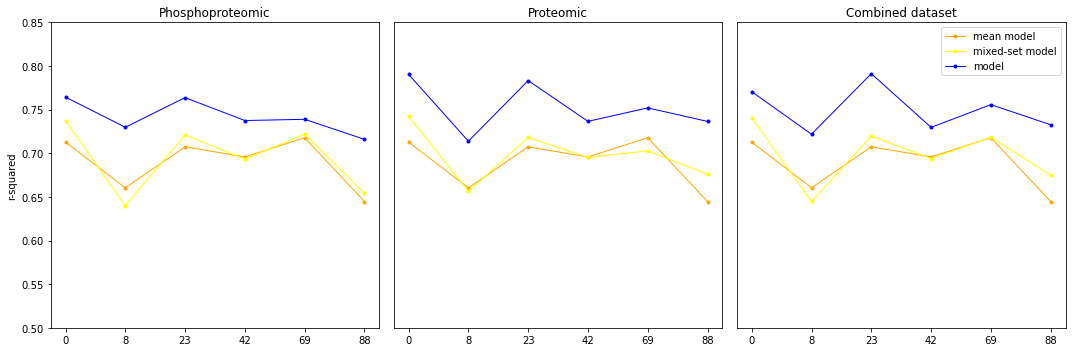

In [128]:
model_type = 'Deep_NN'

shap_df_full1 = pd.read_csv(f'Targets/{model_type}/model performance/phospho/features_phospho.csv')
shap_df_drugs1 = pd.read_csv(f'Targets/{model_type}/model performance/proteomic/features_proteomic.csv')
shap_df_features1 = pd.read_csv(f'Targets/{model_type}/model performance/full_network/features_full_network.csv')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1
axes[0].plot(shap_df_full1['rs'].astype(str), shap_df_full1['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[0].plot(shap_df_full1['rs'].astype(str), shap_df_full1['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[0].plot(shap_df_full1['rs'].astype(str), shap_df_full1['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[0].set_title('Phosphoproteomic')

# Plot 2
axes[1].plot(shap_df_drugs1['rs'].astype(str), shap_df_drugs1['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[1].plot(shap_df_drugs1['rs'].astype(str), shap_df_drugs1['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[1].plot(shap_df_drugs1['rs'].astype(str), shap_df_drugs1['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[1].set_title('Proteomic')

# Plot 3
axes[2].plot(shap_df_features1['rs'].astype(str), shap_df_features1['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[2].plot(shap_df_features1['rs'].astype(str), shap_df_features1['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[2].plot(shap_df_features1['rs'].astype(str), shap_df_features1['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[2].set_title('Combined dataset')

axes[2].legend(["mean model", "mixed-set model", "model"], loc=0)

axes[0].set_ylabel('r-squared')

axes[0].set_ylim(0.5, 0.85)
axes[1].set_ylim(0.5, 0.85)
axes[2].set_ylim(0.5, 0.85)

axes[1].yaxis.set_ticks([])
axes[2].yaxis.set_ticks([])

# Adjust spacing between subplots
plt.tight_layout()

plt.savefig('Targets/DNN_features_lines')

# Display the plots
plt.show()

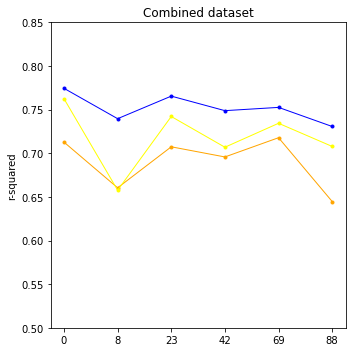

In [127]:
shap_df_features = pd.read_csv(f'Targets/CNN/model performance/full_network/features_full_network.csv')

fig, axes = plt.subplots(1, 1, figsize=(5, 5))

# Plot 1
axes.plot(shap_df_features['rs'].astype(str), shap_df_features['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes.plot(shap_df_features['rs'].astype(str), shap_df_features['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes.plot(shap_df_features['rs'].astype(str), shap_df_features['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes.set_title('Combined dataset')
axes.set_ylim(0.5, 0.85)

axes.set_ylabel('r-squared')


# Adjust spacing between subplots
plt.tight_layout()

plt.savefig('Targets/CNN_features_combined dataset')

# Display the plots
plt.show()

In [ ]:
# extract pearson info from df
shap_df_features["model_pearson"] = [float(f'{x[8]}{x[9]}{x[10]}{x[11]}{x[12]}') for x in shap_df_features["model_pearson"]]

In [ ]:
print(f'r2: {mean(shap_df_features["model_r2"])}\n MSE: {mean(shap_df_features["model_MSE"])}\n sd: {mean(shap_df_features["model_pearson"])}')

In [ ]:
np.std(shap_df_features["model_r2"])

## Proteomic and full_network for drugs/feats and drugs in Deep_NN

In [ ]:
print(f'r2: {mean(metrics40["model_r2"])}\n MSE: {mean(metrics40["model_MSE"])}\n sd: {np.std(metrics40["model_r2"])}')

In [129]:
metrics10 = pd.read_csv(f'Targets/Deep_NN/model performance/proteomic/drugs_features_proteomic.csv')
metrics20 = pd.read_csv(f'Targets/Deep_NN/model performance/proteomic/drugs_proteomic.csv')
metrics30 = pd.read_csv(f'Targets/Deep_NN/model performance/full_network/drugs_features_full_network.csv')
metrics40 = pd.read_csv(f'Targets/Deep_NN/model performance/full_network/drugs_full_network.csv')

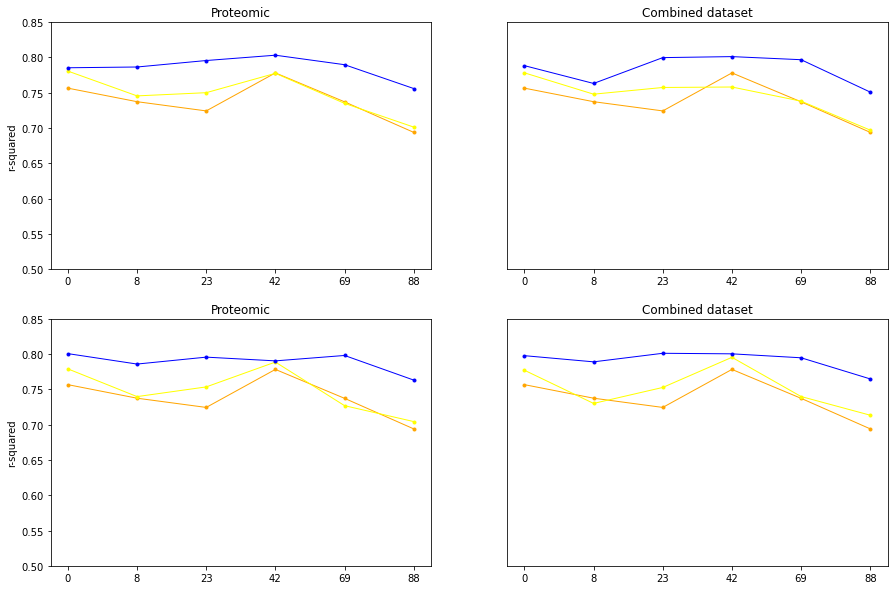

In [131]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1
axes[0,0].plot(metrics10['rs'].astype(str), metrics10['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[0,0].plot(metrics10['rs'].astype(str), metrics10['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[0,0].plot(metrics10['rs'].astype(str), metrics10['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[0,0].set_title('Proteomic')
axes[0,0].set_ylabel('r-squared')

# Plot 2
axes[1,0].plot(metrics20['rs'].astype(str), metrics20['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[1,0].plot(metrics20['rs'].astype(str), metrics20['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[1,0].plot(metrics20['rs'].astype(str), metrics20['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[1,0].set_title('Proteomic')
axes[1,0].set_ylabel('r-squared')


# Plot 3
axes[0,1].plot(metrics30['rs'].astype(str), metrics30['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[0,1].plot(metrics30['rs'].astype(str), metrics30['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[0,1].plot(metrics30['rs'].astype(str), metrics30['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[0,1].set_title('Combined dataset')

# Plot 4
axes[1,1].plot(metrics40['rs'].astype(str), metrics40['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[1,1].plot(metrics40['rs'].astype(str), metrics40['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[1,1].plot(metrics40['rs'].astype(str), metrics40['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[1,1].set_title('Combined dataset')

axes[0,0].set_ylim(0.5, 0.85)
axes[0,1].set_ylim(0.5, 0.85)
axes[1,0].set_ylim(0.5, 0.85)
axes[1,1].set_ylim(0.5, 0.85)

axes[0,1].yaxis.set_ticks([])
axes[1,1].yaxis.set_ticks([])

fig.savefig('Targets/DNN_supplementary.png')

In [ ]:
metrics1 = pd.read_csv(f'Targets/rfr/model performance/proteomic/drugs_proteomic.csv')
metrics2 = pd.read_csv(f'Targets/rfr/model performance/proteomic/features_proteomic.csv')
metrics3 = pd.read_csv(f'Targets/rfr/model performance/full_network/drugs_full_network.csv')
metrics4 = pd.read_csv(f'Targets/rfr/model performance/full_network/features_full_network.csv')

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))



# Plot 1
axes[0,0].plot(metrics1['rs'].astype(str), metrics1['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[0,0].plot(metrics1['rs'].astype(str), metrics1['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[0,0].plot(metrics1['rs'].astype(str), metrics1['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[0,0].set_title('Proteomic')
axes[0,0].set_ylabel('r-squared')

# Plot 2
axes[1,0].plot(metrics2['rs'].astype(str), metrics2['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[1,0].plot(metrics2['rs'].astype(str), metrics2['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[1,0].plot(metrics2['rs'].astype(str), metrics2['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[1,0].set_title('Proteomic')
axes[1,0].set_ylabel('r-squared')

# Plot 3
axes[0,1].plot(metrics3['rs'].astype(str), metrics3['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[0,1].plot(metrics3['rs'].astype(str), metrics3['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[0,1].plot(metrics3['rs'].astype(str), metrics3['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[0,1].set_title('Combined dataset')

# Plot 4
axes[1,1].plot(metrics4['rs'].astype(str), metrics4['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[1,1].plot(metrics4['rs'].astype(str), metrics4['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[1,1].plot(metrics4['rs'].astype(str), metrics4['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[1,1].set_title('Combined dataset')

axes[0,0].set_ylim(0.5, 0.85)
axes[0,1].set_ylim(0.5, 0.85)
axes[1,0].set_ylim(0.5, 0.85)
axes[1,1].set_ylim(0.5, 0.85)

fig.savefig('Targets/rfr_supplementary.png')

## overall model comparison across networks

In [ ]:
dtype='phospho'

#CNN
CNN_full = pd.read_csv(f'Targets/CNN/model performance/{dtype}/drugs_features_{dtype}.csv')
CNN_phos = pd.read_csv(f'Targets/CNN/model performance/{dtype}/drugs_{dtype}.csv')
CNN_prot = pd.read_csv(f'Targets/CNN/model performance/{dtype}/features_{dtype}.csv')
CNN = [mean(CNN_full['model_r2']), mean(CNN_phos['model_r2']), mean(CNN_prot['model_r2'])]
CNN_sd = [np.std(CNN_full['model_r2']), np.std(CNN_phos['model_r2']), np.std(CNN_prot['model_r2'])]

#Deep_NN
Deep_NN_full = pd.read_csv(f'Targets/Deep_NN/model performance/{dtype}/drugs_features_{dtype}.csv')
Deep_NN_phos = pd.read_csv(f'Targets/Deep_NN/model performance/{dtype}/drugs_{dtype}.csv')
Deep_NN_prot = pd.read_csv(f'Targets/Deep_NN/model performance/{dtype}/features_{dtype}.csv')
DNN = [mean(Deep_NN_full['model_r2']), mean(Deep_NN_phos['model_r2']), mean(Deep_NN_prot['model_r2'])]
DNN_sd = [np.std(Deep_NN_full['model_r2']), np.std(Deep_NN_phos['model_r2']), np.std(Deep_NN_prot['model_r2'])]


#xgb
xgb_full = pd.read_csv(f'Targets/xgb/model performance/{dtype}/drugs_features_{dtype}.csv')
xgb_phos = pd.read_csv(f'Targets/xgb/model performance/{dtype}/drugs_{dtype}.csv')
xgb_prot = pd.read_csv(f'Targets/xgb/model performance/{dtype}/features_{dtype}.csv')
xgb = [mean(xgb_full['model_r2']), mean(xgb_phos['model_r2']), mean(xgb_prot['model_r2'])]
xgb_sd = [np.std(xgb_full['model_r2']), np.std(xgb_phos['model_r2']), np.std(xgb_prot['model_r2'])]

#rfr
rfr_full = pd.read_csv(f'Targets/rfr/model performance/{dtype}/drugs_features_{dtype}.csv')
rfr_phos = pd.read_csv(f'Targets/rfr/model performance/{dtype}/drugs_{dtype}.csv')
rfr_prot = pd.read_csv(f'Targets/rfr/model performance/{dtype}/features_{dtype}.csv')
rfr = [mean(rfr_full['model_r2']), mean(rfr_phos['model_r2']), mean(rfr_prot['model_r2'])]
rfr_sd = [np.std(rfr_full['model_r2']), np.std(rfr_phos['model_r2']), np.std(rfr_prot['model_r2'])]

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]

Network = ("drugs/features", "drugs", "features")
r_squared_means = {
    'CNN': CNN,
    'DNN': DNN,
    'rfr': rfr,
    'xgb': xgb
}

# Calculate standard deviations for each model
r_squared_std = {
    'CNN_sd': CNN_sd,
    'DNN_sd': DNN_sd,
    'rfr_sd': rfr_sd,
    'xgb_sd': xgb_sd
}

x = np.arange(len(Network))  # the label locations
width = 0.10  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(constrained_layout=True)

# Define custom colors for each model's bars
colors = ['orange', 'yellow', 'green', 'red']

for model, r in r_squared_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, r, width, label=model, color=colors[multiplier])
    #ax.bar_label(rects, padding=10)
    ax.errorbar(x + offset, r, yerr=r_squared_std[model+'_sd'], fmt='none', color='black', capsize=5)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('r-squared')
ax.set_title('Phosphoproteomic')
ax.set_xticks(x + width * (multiplier - 2.5))  # Adjusted the tick positions
ax.set_xticklabels(Network, style='italic')
ax.legend(loc='upper right')
ax.set_ylim(0.5, 0.9)

fig.savefig('Targets/phospho_targets_comparison.png')

In [ ]:
dtype='proteomic'

#CNN
CNN_full = pd.read_csv(f'Targets/CNN/model performance/{dtype}/drugs_features_{dtype}.csv')
CNN_phos = pd.read_csv(f'Targets/CNN/model performance/{dtype}/drugs_{dtype}.csv')
CNN_prot = pd.read_csv(f'Targets/CNN/model performance/{dtype}/features_{dtype}.csv')
CNN = [mean(CNN_full['model_r2']), mean(CNN_phos['model_r2']), mean(CNN_prot['model_r2'])]
CNN_sd = [np.std(CNN_full['model_r2']), np.std(CNN_phos['model_r2']), np.std(CNN_prot['model_r2'])]

#Deep_NN
Deep_NN_full = pd.read_csv(f'Targets/Deep_NN/model performance/{dtype}/drugs_features_{dtype}.csv')
Deep_NN_phos = pd.read_csv(f'Targets/Deep_NN/model performance/{dtype}/drugs_{dtype}.csv')
Deep_NN_prot = pd.read_csv(f'Targets/Deep_NN/model performance/{dtype}/features_{dtype}.csv')
DNN = [mean(Deep_NN_full['model_r2']), mean(Deep_NN_phos['model_r2']), mean(Deep_NN_prot['model_r2'])]
DNN_sd = [np.std(Deep_NN_full['model_r2']), np.std(Deep_NN_phos['model_r2']), np.std(Deep_NN_prot['model_r2'])]


#xgb
xgb_full = pd.read_csv(f'Targets/xgb/model performance/{dtype}/drugs_features_{dtype}.csv')
xgb_phos = pd.read_csv(f'Targets/xgb/model performance/{dtype}/drugs_{dtype}.csv')
xgb_prot = pd.read_csv(f'Targets/xgb/model performance/{dtype}/features_{dtype}.csv')
xgb = [mean(xgb_full['model_r2']), mean(xgb_phos['model_r2']), mean(xgb_prot['model_r2'])]
xgb_sd = [np.std(xgb_full['model_r2']), np.std(xgb_phos['model_r2']), np.std(xgb_prot['model_r2'])]

#rfr
rfr_full = pd.read_csv(f'Targets/rfr/model performance/{dtype}/drugs_features_{dtype}.csv')
rfr_phos = pd.read_csv(f'Targets/rfr/model performance/{dtype}/drugs_{dtype}.csv')
rfr_prot = pd.read_csv(f'Targets/rfr/model performance/{dtype}/features_{dtype}.csv')
rfr = [mean(rfr_full['model_r2']), mean(rfr_phos['model_r2']), mean(rfr_prot['model_r2'])]
rfr_sd = [np.std(rfr_full['model_r2']), np.std(rfr_phos['model_r2']), np.std(rfr_prot['model_r2'])]



In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]

Network = ("drugs/features", "drugs", "features")
r_squared_means = {
    'CNN': CNN,
    'DNN': DNN,
    'rfr': rfr,
    'xgb': xgb
}

# Calculate standard deviations for each model
r_squared_std = {
    'CNN_sd': CNN_sd,
    'DNN_sd': DNN_sd,
    'rfr_sd': rfr_sd,
    'xgb_sd': xgb_sd
}

x = np.arange(len(Network))  # the label locations
width = 0.10  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(constrained_layout=True)

# Define custom colors for each model's bars
colors = ['orange', 'yellow', 'green', 'red']

for model, r in r_squared_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, r, width, label=model, color=colors[multiplier])
    #ax.bar_label(rects, padding=10)
    ax.errorbar(x + offset, r, yerr=r_squared_std[model+'_sd'], fmt='none', color='black', capsize=5)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('r-squared')
ax.set_title('Proteomic')
ax.set_xticks(x + width * (multiplier - 2.5))  # Adjusted the tick positions
ax.set_xticklabels(Network, style='italic')
ax.legend(loc='upper right')
ax.set_ylim(0.5, 0.9)

fig.savefig('Targets/proteomic_targets_comparison.png')

In [ ]:
dtype='full_network'

#CNN
CNN_full = pd.read_csv(f'Targets/CNN/model performance/{dtype}/drugs_features_{dtype}.csv')
CNN_phos = pd.read_csv(f'Targets/CNN/model performance/{dtype}/drugs_{dtype}.csv')
CNN_prot = pd.read_csv(f'Targets/CNN/model performance/{dtype}/features_{dtype}.csv')
CNN = [mean(CNN_full['model_r2']), mean(CNN_phos['model_r2']), mean(CNN_prot['model_r2'])]
CNN_sd = [np.std(CNN_full['model_r2']), np.std(CNN_phos['model_r2']), np.std(CNN_prot['model_r2'])]

#Deep_NN
Deep_NN_full = pd.read_csv(f'Targets/Deep_NN/model performance/{dtype}/drugs_features_{dtype}.csv')
Deep_NN_phos = pd.read_csv(f'Targets/Deep_NN/model performance/{dtype}/drugs_{dtype}.csv')
Deep_NN_prot = pd.read_csv(f'Targets/Deep_NN/model performance/{dtype}/features_{dtype}.csv')
DNN = [mean(Deep_NN_full['model_r2']), mean(Deep_NN_phos['model_r2']), mean(Deep_NN_prot['model_r2'])]
DNN_sd = [np.std(Deep_NN_full['model_r2']), np.std(Deep_NN_phos['model_r2']), np.std(Deep_NN_prot['model_r2'])]


#xgb
xgb_full = pd.read_csv(f'Targets/xgb/model performance/{dtype}/drugs_features_{dtype}.csv')
xgb_phos = pd.read_csv(f'Targets/xgb/model performance/{dtype}/drugs_{dtype}.csv')
xgb_prot = pd.read_csv(f'Targets/xgb/model performance/{dtype}/features_{dtype}.csv')
xgb = [mean(xgb_full['model_r2']), mean(xgb_phos['model_r2']), mean(xgb_prot['model_r2'])]
xgb_sd = [np.std(xgb_full['model_r2']), np.std(xgb_phos['model_r2']), np.std(xgb_prot['model_r2'])]

#rfr
rfr_full = pd.read_csv(f'Targets/rfr/model performance/{dtype}/drugs_features_{dtype}.csv')
rfr_phos = pd.read_csv(f'Targets/rfr/model performance/{dtype}/drugs_{dtype}.csv')
rfr_prot = pd.read_csv(f'Targets/rfr/model performance/{dtype}/features_{dtype}.csv')
rfr = [mean(rfr_full['model_r2']), mean(rfr_phos['model_r2']), mean(rfr_prot['model_r2'])]
rfr_sd = [np.std(rfr_full['model_r2']), np.std(rfr_phos['model_r2']), np.std(rfr_prot['model_r2'])]

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]

Network = ("drugs/features", "drugs", "features")
r_squared_means = {
    'CNN': CNN,
    'DNN': DNN,
    'rfr': rfr,
    'xgb': xgb
}

# Calculate standard deviations for each model
r_squared_std = {
    'CNN_sd': CNN_sd,
    'DNN_sd': DNN_sd,
    'rfr_sd': rfr_sd,
    'xgb_sd': xgb_sd
}

x = np.arange(len(Network))  # the label locations
width = 0.10  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(constrained_layout=True)

# Define custom colors for each model's bars
colors = ['orange', 'yellow', 'green', 'red']

for model, r in r_squared_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, r, width, label=model, color=colors[multiplier])
    #ax.bar_label(rects, padding=10)
    ax.errorbar(x + offset, r, yerr=r_squared_std[model+'_sd'], fmt='none', color='black', capsize=5)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('r-squared')
ax.set_title('Combined dataset')
ax.set_xticks(x + width * (multiplier - 2.5))  # Adjusted the tick positions
ax.set_xticklabels(Network, style='italic')
ax.legend(loc='upper right')
ax.set_ylim(0.5, 0.9)

fig.savefig('Targets/full_targets_comparison.png')

# SHAP for drug targets

In [ ]:
#train-test-split
X_train, X_test, y_train, y_test = cell_line_split(dd_X_main, dd_y_main, test_size=0.2, random_state = 23)
print(f'dd_X_main.shape: {dd_X_main.shape}')
print(f'X_train.shape: {X_train.shape}, X_test.shape: {X_test.shape}')

In [ ]:
#train-test-split
xo_train, xo_test = cell_line_split(dd_x_all, y=None, test_size=0.2, random_state = 23)
xd_train, xd_test = cell_line_split(dd_x_drug, y=None, test_size=0.2, random_state = 23)
y_train, y_test = cell_line_split(dd_y_main, y=None, test_size=0.2, random_state = 23)

print(f'dd_x_all.shape: {dd_x_all.shape}')
print(f'xo_train.shape: {xo_train.shape}, X_test.shape: {xo_test.shape}')

print(f'dd_x_drug.shape: {dd_x_drug.shape}')
print(f'xd_train.shape: {xd_train.shape}, X_test.shape: {xd_test.shape}')

## build model

In [ ]:
%%time
model_type == 'Deep_NN'
if model_type == 'Deep_NN':
    ## fit the model

    model = build_Deep_NN(xo_train, xd_train, learning_rate, momentum, initializer_seed, complexity = 4)
    history = model.fit([xo_train, xd_train], y_train,
                        validation_data=([xo_test, xd_test], y_test),
                        epochs=num_epochs, 
                        batch_size=None, 
                        verbose=0, 
                        callbacks=callbacks_list)
    shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough

    # DeepExplainer to explain predictions of the model
    explainer = shap.DeepExplainer(model, [np.array(xo_train), np.array(xd_train)])

elif model_type == 'rfr':

    #run rfr
    classify = RandomForestRegressor(n_jobs=-1, max_depth=300, n_estimators=200)

    #fit model
    classify.fit(X_train, y_train)

    #creates explainer instance
    explainer = shap.explainers.Tree(classify, X_train)

elif model_type == 'xgb':
    #run xgb
    xgb = XGBRegressor(max_depth = 75, 
                       n_estimators = 300, 
                       seed = 42, 
                       min_child_weight = 3, 
                       gamma = 0, 
                       colsample_bytree = 0.3, 
                       reg_alpha = 0.1,
                       n_jobs=-1)

    #fit model
    xgb.fit(X_train, y_train)

    #creates explainer instance
    explainer = shap.explainers.Tree(xgb, X_train)

## significant SHAP finder

In [ ]:
%%time
indexes, features, targets = SHAP_targets(dd_X_main, explainer, X_test, y_test, dtype = 'phospho')

In [ ]:
number_of_targs = [len(x) for x in targets[0]]

In [ ]:
SHAP_df = table_make('SHAPs',
           [indexes, features[0], features[1], features[2], features[3], targets[0], number_of_targs, targets[1], targets[2], targets[3]],
           ['cl:drug',' total number of features', 'target percentage of total', 'total number of significant features', 'target percentage of significant', 'drug targets', 'number of targets', 'percent significant', 'significant targets', 'insignificant targets'], file = False)
SHAP_df = SHAP_df.sort_values('percent significant', ascending=False)
SHAP_df.to_csv(f'Targets/{model_type}/explainability/SHAP/{dtype}/{test_type}_{dtype}2.csv')

## SHAP plot

In [ ]:
index = index_finder('KYSE-150::Bosutinib', X_test)
index

In [ ]:
#specify the cell line and drugs that are tested
cell_line, drug = list(X_test.index)[index].split('::')

In [ ]:
print(f'cell line: {cell_line}\ndrug: {drug}\nIC50: {y_test[f"{cell_line}::{drug}"]}')

In [ ]:
if model_type == 'rfr':    
    # make a shap value array for the prediction
    shaps = explainer.shap_values(X_test.loc[f'{cell_line}::{drug}'], y_test[f'{cell_line}::{drug}'], check_additivity=False)
    
elif model_type == 'Deep_NN':
    shaps = explainer.shap_values([np.array([xo_test.loc[f'{cell_line}::{drug}']]), np.array([xd_test.loc[f'{cell_line}::{drug}']])])

In [ ]:
dtype = 'full_network'

# drug list and their associated proteins
if dtype == 'phospho':
    dd = drugData(X_main_phos, isPhospho = True)
    target_lists = [i.split(', ') for i in dd['Targets']]
    
    drug_dict = {dd.index[i]:target_lists[i] for i in range(len(target_lists))}

elif dtype == 'proteomic':
    dd = drugData(X_main_prot)
    target_lists = [i.split('; ') for i in dd['Targets']]
    
    drug_dict = {dd.index[i]:target_lists[i] for i in range(len(target_lists))}

if dtype == 'full_network':
    from data_makers import drugData
    dd_phos = drugData(dd_X_main, isPhospho = True)
    target_lists_phos = [i.split(', ') for i in dd_phos['Targets']]

    #prot
    from data_makers import drugData
    dd_prot = drugData(dd_X_main)
    target_lists_prot = [i.split('; ') for i in dd_prot['Targets']]
        
    # account for disparity between phos and prot drugs available
    overlap_target_lists = [target_lists_phos[i] + target_lists_prot[i] for i in range(len(target_lists_phos))]
    missingIndexes = len(target_lists_prot) - len(overlap_target_lists) # the added protein indexes not covered by phos indexes
    prot_to_add = target_lists_prot[-missingIndexes:] # the section of array that these indexes cover
    target_lists = overlap_target_lists + prot_to_add
                
    drug_dict = {dd_prot.index[i]:target_lists[i] for i in range(len(target_lists))}

#targets for the specific drug
shap_targets = drug_dict[drug]

In [ ]:
if model_type == 'rfr':
    #find where the targets are situated in the shap list
    target_and_index = [[i, v] for i, v in enumerate(X_test.loc[f'{cell_line}::{drug}'].index) if v in shap_targets]
    #separate them for the plot
    protein_targs = [l[1] for l in target_and_index]
    indexes = [l[0] for l in target_and_index]
elif model_type == 'Deep_NN':
    #find where the targets are situated in the shap list
    target_and_index = [[i, v] for i, v in enumerate(xo_test.loc[f'{cell_line}::{drug}'].index) if v in shap_targets]
    #separate them for the plot
    protein_targs = [l[1] for l in target_and_index]
    indexes = [l[0] for l in target_and_index]

In [ ]:
plt.rcParams['figure.figsize'] = [20, 20]
rot = plt.xticks(rotation=45)

# Sample data
if model_type == 'rfr':
    x = list(range(0, len(X_test.loc[f'{cell_line}::{drug}'])))
elif model_type == 'Deep_NN':
    x = list(range(0, len(xo_test.loc[f'{cell_line}::{drug}'])))
y = shaps[0][0][0]

# List of indices for points to be crosses
cross_indices = indexes

# Add axis labels
plt.xlabel('index')
plt.ylabel('shapley scores')

# Add a title
plt.title('shapley scores for a DNN model trained on features_full_network predicting SNU-387::Pemetrexed')

# Plotting
plt.scatter(x, y, marker='o')  # Plot circles for all points
plt.scatter([x[i] for i in cross_indices], [y[i] for i in cross_indices], marker='x', color='red')  # Plot crosses for specific points

plt.savefig('Targets/example_scatter_SNU-387::Pemetrexed')

## significance plot

In [70]:
test_type1 = 'drugs_features'

In [71]:
method = 'Targets'
model_type1 = 'rfr'
dtype1 = 'full_network'
analysis = 'SHAP'
SHAP_df1 = pd.read_csv(f'{method}/{model_type1}/explainability/{analysis}/{dtype1}/{test_type1}_{dtype1}2.csv')
label1 = f'RF_{analysis}_Combined_data'

In [72]:
method = 'Targets'
model_type1 = 'rfr'
dtype1 = 'proteomic'
analysis = 'SHAP'
SHAP_df2 = pd.read_csv(f'{method}/{model_type1}/explainability/{analysis}/{dtype1}/{test_type1}_{dtype1}2.csv')
label2 = f'RF_{analysis}_Proteomic'

In [73]:
method = 'Targets'
model_type1 = 'Deep_NN'
dtype1 = 'full_network'
analysis = 'SHAP'
SHAP_df3 = pd.read_csv(f'{method}/{model_type1}/explainability/{analysis}/{dtype1}/{test_type1}_{dtype1}2.csv')
label3 = f'DNN_{analysis}_Combined_data'

In [74]:
method = 'Targets'
model_type1 = 'Deep_NN'
dtype1 = 'proteomic'
analysis = 'SHAP'
SHAP_df4 = pd.read_csv(f'{method}/{model_type1}/explainability/{analysis}/{dtype1}/{test_type1}_{dtype1}2.csv')
label4 = f'DNN_{analysis}_Proteomic'

In [75]:
method = 'Targets'
model_type1 = 'Deep_NN'
dtype1 = 'full_network'
analysis = 'IG'
SHAP_df5 = pd.read_csv(f'{method}/{model_type1}/explainability/{analysis}/{dtype1}/{test_type1}_{dtype1}2.csv')
label5 = f'DNN_{analysis}_Combined_data'

In [76]:
method = 'Targets'
model_type1 = 'Deep_NN'
dtype1 = 'proteomic'
analysis = 'IG'
SHAP_df6 = pd.read_csv(f'{method}/{model_type1}/explainability/{analysis}/{dtype1}/{test_type1}_{dtype1}2.csv')
label6 = f'DNN_{analysis}_Proteomic'

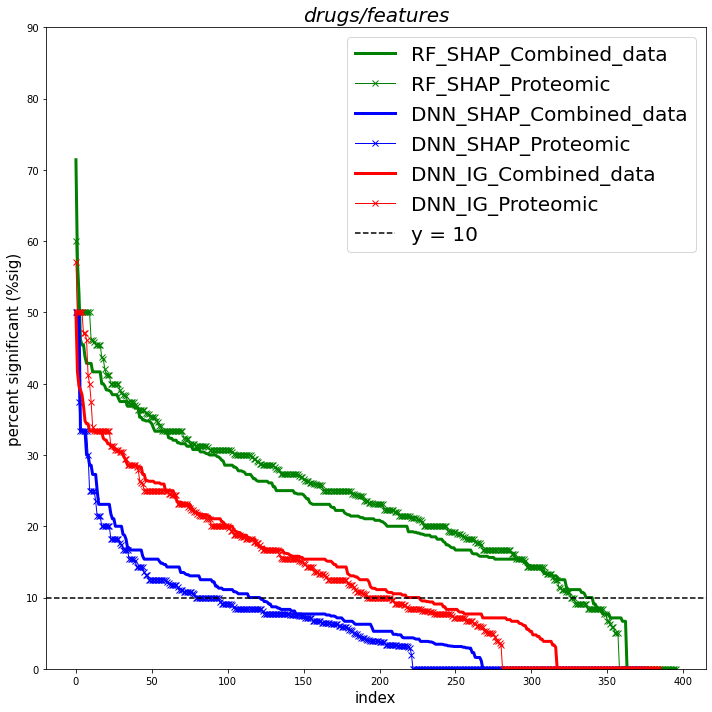

In [77]:
#plot for % comparison
plt.rcParams['figure.figsize'] = [10, 10]

plt.plot(list(SHAP_df1.index), SHAP_df1['percent significant'], label= label1, linestyle='-', color='green', linewidth=3)
plt.plot(list(SHAP_df2.index), SHAP_df2['percent significant'], label= label2, linestyle='-', marker='x', color='green', linewidth=1)
plt.plot(list(SHAP_df3.index), SHAP_df3['percent significant'], label= label3, linestyle='-', color='blue', linewidth=3)
plt.plot(list(SHAP_df4.index), SHAP_df4['percent significant'], label= label4, linestyle='-', marker='x', color='blue', linewidth=1)
plt.plot(list(SHAP_df5.index), SHAP_df5['percent significant'], label= label5, linestyle='-', color='red', linewidth=3)
plt.plot(list(SHAP_df6.index), SHAP_df6['percent significant'], label= label6, linestyle='-', marker='x', color='red', linewidth=1)
plt.axhline(y=10, color='black', linestyle='--', label='y = 10')

# Add axis labels
plt.xlabel('index', fontsize=15)
plt.ylabel('percent significant (%sig)', fontsize = 15)

# Add a title
plt.title('drugs/features', style='italic', fontsize=20)

plt.legend(fontsize=20)

plt.ylim(0, 90)

# Adjust spacing between subplots
plt.tight_layout()

plt.savefig(f'Targets/%sig/{test_type1}_%significant_comparison_final2')

# Display the plots
plt.show()


In [26]:
metrics1 = pd.read_csv(f'Targets/Deep_NN/model performance/proteomic/drugs_features_proteomic.csv')
metrics2 = pd.read_csv(f'Targets/Deep_NN/model performance/full_network/drugs_features_full_network.csv')
metrics3 = pd.read_csv(f'Targets/rfr/model performance/proteomic/drugs_features_proteomic.csv')
metrics4 = pd.read_csv(f'Targets/rfr/model performance/full_network/drugs_features_full_network.csv')

In [ ]:
# Plot 2

plt.plot(metrics1['rs'].astype(str), metrics1['model_r2'], linestyle='-', marker='x', color='blue', linewidth=1)
plt.plot(metrics2['rs'].astype(str), metrics2['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
plt.plot(metrics3['rs'].astype(str), metrics3['model_r2'], linestyle='-', marker='x', color='green', linewidth=1)
plt.plot(metrics4['rs'].astype(str), metrics4['model_r2'], linestyle='-', marker='.', color='green', linewidth=1)

plt.title('performance')
plt.xlabel('seed')
plt.ylabel('r-squared')
plt.ylim(0.5, 0.85)

plt.savefig('Targets/drugs_features_performance_comparison.png')

## phospho comparison

In [78]:
test_type1 = 'features'

In [111]:
method = 'Targets'
model_type1 = 'rfr'
dtype1 = 'phospho'
analysis = 'SHAP'
SHAP_df1 = pd.read_csv(f'{method}/{model_type1}/explainability/{analysis}/{dtype1}/{test_type1}_{dtype1}2.csv')
label1 = f'RF_{analysis}_Phospho'

In [112]:
method = 'Targets'
model_type1 = 'rfr'
dtype1 = 'proteomic'
analysis = 'SHAP'
SHAP_df2 = pd.read_csv(f'{method}/{model_type1}/explainability/{analysis}/{dtype1}/{test_type1}_{dtype1}2.csv')
label2 = f'RF_{analysis}_Proteomic'

In [113]:
method = 'Targets'
model_type1 = 'rfr'
dtype1 = 'full_network'
analysis = 'SHAP'
SHAP_df3 = pd.read_csv(f'{method}/{model_type1}/explainability/{analysis}/{dtype1}/{test_type1}_{dtype1}2.csv')
label3 = f'RF_{analysis}_Combined_data'

In [114]:
method = 'Targets'
model_type1 = 'Deep_NN'
dtype1 = 'phospho'
analysis = 'SHAP'
SHAP_df4 = pd.read_csv(f'{method}/{model_type1}/explainability/{analysis}/{dtype1}/{test_type1}_{dtype1}2.csv')
label4 = f'DNN_{analysis}_Phospho'

In [115]:
method = 'Targets'
model_type1 = 'Deep_NN'
dtype1 = 'proteomic'
analysis = 'SHAP'
SHAP_df5 = pd.read_csv(f'{method}/{model_type1}/explainability/{analysis}/{dtype1}/{test_type1}_{dtype1}2.csv')
label5 = f'DNN_{analysis}_Proteomic'

In [116]:
method = 'Targets'
model_type1 = 'Deep_NN'
dtype1 = 'full_network'
analysis = 'SHAP'
SHAP_df6 = pd.read_csv(f'{method}/{model_type1}/explainability/{analysis}/{dtype1}/{test_type1}_{dtype1}2.csv')
label6 = f'DNN_{analysis}_Combined_data'

In [117]:
method = 'Targets'
model_type1 = 'Deep_NN'
dtype1 = 'phospho'
analysis = 'IG'
SHAP_df7 = pd.read_csv(f'{method}/{model_type1}/explainability/{analysis}/{dtype1}/{test_type1}_{dtype1}2.csv')
label7 = f'DNN_{analysis}_Phospho'

In [118]:
method = 'Targets'
model_type1 = 'Deep_NN'
dtype1 = 'proteomic'
analysis = 'IG'
SHAP_df8 = pd.read_csv(f'{method}/{model_type1}/explainability/{analysis}/{dtype1}/{test_type1}_{dtype1}2.csv')
label8 = f'DNN_{analysis}_Proteomic'

In [119]:
method = 'Targets'
model_type1 = 'Deep_NN'
dtype1 = 'full_network'
analysis = 'IG'
SHAP_df9 = pd.read_csv(f'{method}/{model_type1}/explainability/{analysis}/{dtype1}/{test_type1}_{dtype1}2.csv')
label9 = f'DNN_{analysis}_Combined_data'

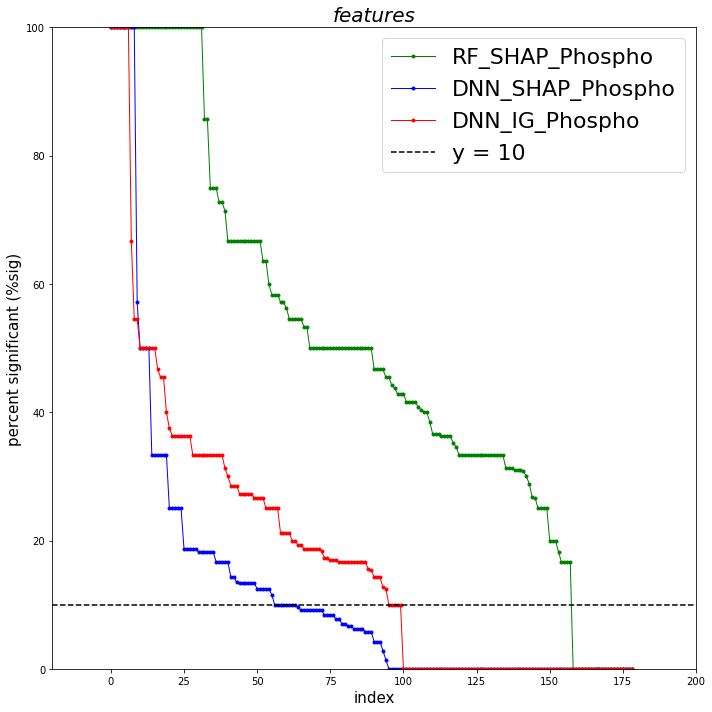

In [125]:
#plot for % comparison
plt.rcParams['figure.figsize'] = [10, 10]

plt.plot(list(SHAP_df1.index), SHAP_df1['percent significant'], label= label1, linestyle='-', marker='.', color='green', linewidth=1)
#plt.plot(list(SHAP_df2.index), SHAP_df2['percent significant'], label= label2, linestyle='-', marker='x', color='green', linewidth=1)
#plt.plot(list(SHAP_df3.index), SHAP_df3['percent significant'], label= label3, linestyle='-', color='green', linewidth=3)
plt.plot(list(SHAP_df4.index), SHAP_df4['percent significant'], label= label4, linestyle='-', marker='.', color='blue', linewidth=1)
#plt.plot(list(SHAP_df5.index), SHAP_df5['percent significant'], label= label5, linestyle='-', marker='x', color='blue', linewidth=1)
#plt.plot(list(SHAP_df6.index), SHAP_df6['percent significant'], label= label6, linestyle='-', color='blue', linewidth=3)
plt.plot(list(SHAP_df7.index), SHAP_df7['percent significant'], label= label7, linestyle='-', marker='.', color='red', linewidth=1)
#plt.plot(list(SHAP_df8.index), SHAP_df8['percent significant'], label= label8, linestyle='-', marker='x', color='red', linewidth=1)
#plt.plot(list(SHAP_df9.index), SHAP_df9['percent significant'], label= label9, linestyle='-', color='red', linewidth=3)
plt.axhline(y=10, color='black', linestyle='--', label='y = 10')

# Add axis labels
plt.xlabel('index', fontsize=15)
plt.ylabel('percent significant (%sig)', fontsize=15)

# Add a title
plt.title('features', style='italic', fontsize=20)

plt.legend(fontsize=22)

plt.ylim(0, 100)
plt.xlim(-20, 200)

# Adjust spacing between subplots
plt.tight_layout()

plt.savefig(f'Targets/%sig/phospho_features_%significant_comparison_final2')

# Display the plots
plt.show()


# Integrated gradients for targets

In [ ]:
#train-test-split
X_train, X_test, y_train, y_test = cell_line_split(dd_X_main, dd_y_main, test_size=0.2, random_state = 23)
print(f'dd_X_main.shape: {dd_X_main.shape}')
print(f'X_train.shape: {X_train.shape}, X_test.shape: {X_test.shape}')

In [ ]:
#train-test-split
xo_train, xo_test = cell_line_split(dd_x_all, y=None, test_size=0.2, random_state = 23)
xd_train, xd_test = cell_line_split(dd_x_drug, y=None, test_size=0.2, random_state = 23)
y_train, y_test = cell_line_split(dd_y_main, y=None, test_size=0.2, random_state = 23)

print(f'dd_x_all.shape: {dd_x_all.shape}')
print(f'xo_train.shape: {xo_train.shape}, X_test.shape: {xo_test.shape}')

print(f'dd_x_drug.shape: {dd_x_drug.shape}')
print(f'xd_train.shape: {xd_train.shape}, X_test.shape: {xd_test.shape}')

## build model

In [ ]:
%%time
## fit the model

model = build_Deep_NN(xo_train, xd_train, learning_rate, momentum, initializer_seed, complexity = 4)
history = model.fit([xo_train, xd_train], y_train,
                    validation_data=([xo_test, xd_test], y_test),
                    epochs=num_epochs, 
                    batch_size=None, 
                    verbose=0, 
                    callbacks=callbacks_list)

In [ ]:
#initialise IG explainer
ig  = IntegratedGradients(model,
                          layer=None,
                          target_fn=None,
                          method="gausslegendre",
                          n_steps=50,
                          internal_batch_size=100)

## test model

In [ ]:
%%time
indexes, targets, percent_sig, sig_targs, insig_targs = IG_targets_NN(dd_X_main, ig, [xo_test, xd_test], y_test, dtype = 'mix')

In [ ]:
number_of_targs = [len(x) for x in targets]

In [ ]:
IG_df = table_make('IG',
           [indexes, targets, number_of_targs, percent_sig, sig_targs, insig_targs],
           ['cl:drug', 'drug targets', 'number of targets', 'percent significant', 'significant targets', 'insignificant targets'], file = False)
IG_df = IG_df.sort_values('percent significant', ascending=False)
IG_df.to_csv(f'Targets/{model_type}/explainability/IG/{dtype}/features_{dtype}.csv')

# EMDRs

In [ ]:
#train-test-split
X_train, X_test, y_train, y_test = cell_line_split(dd_X_main, dd_y_main, test_size=0.2, random_state = 23)
print(f'dd_X_main.shape: {dd_X_main.shape}')
print(f'X_train.shape: {X_train.shape}, X_test.shape: {X_test.shape}')

In [ ]:
#train-test-split
xo_train, xo_test = cell_line_split(dd_x_all, y=None, test_size=0.2, random_state = 23)
xd_train, xd_test = cell_line_split(dd_x_drug, y=None, test_size=0.2, random_state = 23)
y_train, y_test = cell_line_split(dd_y_main, y=None, test_size=0.2, random_state = 23)

print(f'dd_x_all.shape: {dd_x_all.shape}')
print(f'xo_train.shape: {xo_train.shape}, X_test.shape: {xo_test.shape}')

print(f'dd_x_drug.shape: {dd_x_drug.shape}')
print(f'xd_train.shape: {xd_train.shape}, X_test.shape: {xd_test.shape}')

## build model

In [ ]:
%%time

if model_type == 'Deep_NN':
    ## fit the model

    model = build_Deep_NN(xo_train, xd_train, learning_rate, momentum, initializer_seed, complexity = 4)
    history = model.fit([xo_train, xd_train], y_train,
                        validation_data=([xo_test, xd_test], y_test),
                        epochs=num_epochs, 
                        batch_size=None, 
                        verbose=0, 
                        callbacks=callbacks_list)
    shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough

    # DeepExplainer to explain predictions of the model
    explainer = shap.DeepExplainer(model, [np.array(xo_train), np.array(xd_train)])

elif model_type == 'rfr':

    #run rfr
    classify = RandomForestRegressor(n_jobs=-1, max_depth=300, n_estimators=200)

    #fit model
    classify.fit(X_train, y_train)

    #creates explainer instance
    explainer = shap.explainers.Tree(classify, X_train)

elif model_type == 'xgb':
    #run xgb
    xgb = XGBRegressor(max_depth = 75, 
                       n_estimators = 300, 
                       seed = 42, 
                       min_child_weight = 3, 
                       gamma = 0, 
                       colsample_bytree = 0.3, 
                       reg_alpha = 0.1,
                       n_jobs=-1)

    #fit model
    xgb.fit(X_train, y_train)

    #creates explainer instance
    explainer = shap.explainers.Tree(xgb, X_train)

## significant EMDR finder

In [ ]:
%%time
indexes, features, targets = SHAP_EMDR_NN(dd_X_main, explainer, [xo_test, xd_test], y_test, dtype = 'proteomic', strict=True)

In [ ]:
number_of_targs = [len(x) for x in targets[0]]

In [ ]:
SHAP_df = table_make('SHAPs',
           [indexes, features[0], features[1], features[2], features[3], targets[0], number_of_targs, targets[1], targets[2], targets[3]],
           ['cl:drug',' total number of features', 'EMDR percentage of total', 'total number of significant features', 'EMDR percentage of significant', 'EMDRs', 'number of EMDRs', 'percent significant', 'significant EMDRs', 'insignificant EMDRs'], file = False)
SHAP_df = SHAP_df.sort_values('percent significant', ascending=False)
SHAP_df.to_csv(f'EMDR/{model_type}/explainability/SHAP/{dtype}/{test_type}_{dtype}.csv')

## significance plot

In [ ]:
method = 'EMDR'
model_type1 = 'Deep_NN'
dtype1 = 'phospho'
test_type1 = 'drugs'
analysis = 'SHAP'
SHAP_df1 = pd.read_csv(f'{method}/{model_type1}/explainability/{analysis}/{dtype1}/{test_type1}_{dtype1}_notStrict.csv')
label1 = f'{model_type1}_{analysis}_{dtype1}_{test_type1}'

In [ ]:
method = 'EMDR'
model_type1 = 'Deep_NN'
dtype1 = 'proteomic'
test_type1 = 'drugs_features'
analysis = 'SHAP'
SHAP_df2 = pd.read_csv(f'{method}/{model_type1}/explainability/{analysis}/{dtype1}/{test_type1}_{dtype1}.csv')
label2 = f'{model_type1}_{analysis}_{dtype1}_{test_type1}'

In [ ]:
method = 'EMDR'
model_type1 = 'Deep_NN'
dtype1 = 'proteomic'
test_type1 = 'drugs'
analysis = 'SHAP'
SHAP_df3 = pd.read_csv(f'{method}/{model_type1}/explainability/{analysis}/{dtype1}/{test_type1}_{dtype1}.csv')
label3 = f'{model_type1}_{analysis}_{dtype1}_{test_type1}'

In [ ]:
method = 'EMDR'
model_type1 = 'Deep_NN'
dtype1 = 'proteomic'
test_type1 = 'drugs_features'
analysis = 'SHAP'
SHAP_df4 = pd.read_csv(f'{method}/{model_type1}/explainability/{analysis}/{dtype1}/{test_type1}_{dtype1}.csv')
label4 = f'{model_type1}_{analysis}_{dtype1}_{test_type1}'

In [ ]:
method = 'EMDR'
model_type1 = 'Deep_NN'
dtype1 = 'full_network'
test_type1 = 'drugs'
analysis = 'SHAP'
SHAP_df5 = pd.read_csv(f'{method}/{model_type1}/explainability/{analysis}/{dtype1}/{test_type1}_{dtype1}.csv')
label5 = f'{model_type1}_{analysis}_{dtype1}_{test_type1}'

In [ ]:
method = 'EMDR'
model_type1 = 'Deep_NN'
dtype1 = 'proteomic'
test_type1 = 'drugs_features'
analysis = 'SHAP'
SHAP_df6 = pd.read_csv(f'{method}/{model_type1}/explainability/{analysis}/{dtype1}/{test_type1}_{dtype1}.csv')
label6 = f'{model_type1}_{analysis}_{dtype1}_{test_type1}'

In [ ]:
#plot for % comparison
plt.rcParams['figure.figsize'] = [15, 15]

plt.plot(list(SHAP_df1.index), SHAP_df1['percent significant'], label= label1, linestyle='-', marker='.', color='green', linewidth=1)
#plt.plot(list(SHAP_df2.index), SHAP_df2['percent significant'], label= label2, linestyle='-', marker='x', color='green', linewidth=1)
plt.plot(list(SHAP_df3.index), SHAP_df3['percent significant'], label= label3, linestyle='-', marker='.', color='blue', linewidth=1)
#plt.plot(list(SHAP_df4.index), SHAP_df4['percent significant'], label= label4, linestyle='-', marker='x', color='blue', linewidth=1)
plt.plot(list(SHAP_df5.index), SHAP_df5['percent significant'], label= label5, linestyle='-', marker='.', color='red', linewidth=1)
#plt.plot(list(SHAP_df6.index), SHAP_df6['percent significant'], label= label6, linestyle='-', marker='x', color='red', linewidth=1)
plt.axhline(y=10, color='black', linestyle='--', label='y = 10')

# Add axis labels
plt.xlabel('index')
plt.ylabel('percent significant')

# Add a title
plt.title('% significant features determine by post-hoc analysis')

plt.legend()

plt.ylim(0, 80)

# Adjust spacing between subplots
plt.tight_layout()

plt.savefig('EMDR/EMDR_drugs_%significant_comparison')

# Display the plots
plt.show()


# significant drug plot

In [ ]:
#set target
targ = 'Fulvestrant'
test_type1 = 'features'

In [ ]:
method = 'Targets'
model_type1 = 'rfr'
dtype1 = 'full_network'
analysis = 'SHAP'
SHAP_df1 = pd.read_csv(f'{method}/{model_type1}/explainability/{analysis}/{dtype1}/{test_type1}_{dtype1}2.csv')

indexes1, sigs1 = drug_or_cl_sig(targ, SHAP_df1, isDrug=True)

label1 = f'{model_type1}_{analysis}_{dtype1}_{test_type1}'

In [ ]:
method = 'Targets'
model_type1 = 'rfr'
dtype1 = 'proteomic'
analysis = 'SHAP'
SHAP_df2 = pd.read_csv(f'{method}/{model_type1}/explainability/{analysis}/{dtype1}/{test_type1}_{dtype1}2.csv')

indexes2, sigs2 = drug_or_cl_sig(targ, SHAP_df2, isDrug=True)

label2 = f'{model_type1}_{analysis}_{dtype1}_{test_type1}'

In [ ]:
method = 'Targets'
model_type1 = 'Deep_NN'
dtype1 = 'full_network'
analysis = 'SHAP'
SHAP_df3 = pd.read_csv(f'{method}/{model_type1}/explainability/{analysis}/{dtype1}/{test_type1}_{dtype1}2.csv')

indexes3, sigs3 = drug_or_cl_sig(targ, SHAP_df3, isDrug=True)

label3 = f'{model_type1}_{analysis}_{dtype1}_{test_type1}'

In [ ]:
method = 'Targets'
model_type1 = 'Deep_NN'
dtype1 = 'proteomic'
analysis = 'SHAP'
SHAP_df4 = pd.read_csv(f'{method}/{model_type1}/explainability/{analysis}/{dtype1}/{test_type1}_{dtype1}2.csv')

indexes4, sigs4 = drug_or_cl_sig(targ, SHAP_df4, isDrug=True)

label4 = f'{model_type1}_{analysis}_{dtype1}_{test_type1}'

In [ ]:
method = 'Targets'
model_type1 = 'Deep_NN'
dtype1 = 'full_network'
analysis = 'IG'
SHAP_df5 = pd.read_csv(f'{method}/{model_type1}/explainability/{analysis}/{dtype1}/{test_type1}_{dtype1}2.csv')

indexes5, sigs5 = drug_or_cl_sig(targ, SHAP_df5, isDrug=True)

label5 = f'{model_type1}_{analysis}_{dtype1}_{test_type1}'

In [ ]:
method = 'Targets'
model_type1 = 'Deep_NN'
dtype1 = 'proteomic'
analysis = 'IG'
SHAP_df6 = pd.read_csv(f'{method}/{model_type1}/explainability/{analysis}/{dtype1}/{test_type1}_{dtype1}2.csv')

indexes6, sigs6 = drug_or_cl_sig(targ, SHAP_df6, isDrug=True)

label6 = f'{model_type1}_{analysis}_{dtype1}_{test_type1}'

In [ ]:
#plot for % comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

plt.scatter(indexes1, sigs1, label= label1, linestyle='-', marker='.', color='green', linewidth=3)
plt.scatter(indexes2, sigs2, label= label2, linestyle='-', marker='x', color='green', linewidth=3)
plt.scatter(indexes3, sigs3, label= label3, linestyle='-', marker='.', color='blue', linewidth=3)
plt.scatter(indexes4, sigs4, label= label4, linestyle='-', marker='x', color='blue', linewidth=3)
plt.scatter(indexes5, sigs5, label= label5, linestyle='-', marker='.', color='red', linewidth=3)
plt.scatter(indexes6, sigs6, label= label6, linestyle='-', marker='x', color='red', linewidth=3)
plt.axhline(y=10, color='black', linestyle='--', label='y = 10')

# Add axis labels
plt.xlabel('significance rank')
plt.ylabel('percent significant')

# Add a title
plt.title(f'Distribution of significance for {targ}')

plt.legend()

plt.ylim(0, 70)
plt.xlim(-20, 400)

# Adjust spacing between subplots
plt.tight_layout()

#plt.savefig(f'Targets/example_targs/{test_type1}_distribution_significance_{targ}')

# Display the plots
plt.show()
